In [1]:
import nltk
from nltk.corpus import gutenberg
from unidecode import unidecode
from collections import Counter, defaultdict
import re
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [3]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [4]:
print(gutenberg.open('bible-kjv.txt').read()[:588])

[The King James Bible]

The Old Testament of the King James Bible

The First Book of Moses:  Called Genesis


1:1 In the beginning God created the heaven and the earth.

1:2 And the earth was without form, and void; and darkness was upon
the face of the deep. And the Spirit of God moved upon the face of the
waters.

1:3 And God said, Let there be light: and there was light.

1:4 And God saw the light, that it was good: and God divided the light
from the darkness.

1:5 And God called the light Day, and the darkness he called Night.
And the evening and the morning were the first day.


In [5]:
print(re.sub('\s+',' ', gutenberg.open('bible-kjv.txt').read().lower())[:579])

[the king james bible] the old testament of the king james bible the first book of moses: called genesis 1:1 in the beginning god created the heaven and the earth. 1:2 and the earth was without form, and void; and darkness was upon the face of the deep. and the spirit of god moved upon the face of the waters. 1:3 and god said, let there be light: and there was light. 1:4 and god saw the light, that it was good: and god divided the light from the darkness. 1:5 and god called the light day, and the darkness he called night. and the evening and the morning were the first day.


In [6]:
shf = [fileid for fileid in gutenberg.fileids() if fileid.startswith('shakespeare')]
shf

['shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt']

In [7]:
shtxt = ''.join([re.sub('\s+',' ', gutenberg.open(f).read().lower()) for f in shf])
len(shtxt)/5000

73.274

find all the letter trigrams

In [8]:
tri_count = {}
for f in gutenberg.fileids():
    txt = re.sub('\s+',' ', gutenberg.open(f).read().lower())
    if f[:8] in ('austen-e', 'austen-p'): continue  #just sense and sensibility
    if len(txt)/5000 > 90:
       print(f, len(txt), len(txt)/5000)
       tri_count[f.split('.')[0]] = Counter([txt[i:i+3] for i in range(250000-2)]) # 50 blocks of 5000
tri_count['shakespeare'] = Counter([shtxt[i:i+3] for i in range(250000-2)])

austen-sense.txt 668184 133.6368
bible-kjv.txt 4305687 861.1374
chesterton-ball.txt 452568 90.5136
edgeworth-parents.txt 905247 181.0494
melville-moby_dick.txt 1211074 242.2148
milton-paradise.txt 456048 91.2096
whitman-leaves.txt 694556 138.9112


In [9]:
tri_count['shakespeare'].most_common(20)

[(' th', 4212),
 ('the', 2730),
 ('he ', 1824),
 (' an', 1738),
 ('nd ', 1644),
 ('and', 1635),
 ('e, ', 1369),
 (' yo', 1327),
 ('is ', 1327),
 ('you', 1298),
 (' to', 1255),
 ('re ', 1185),
 ('ll ', 1151),
 ('e t', 1136),
 (', a', 1134),
 ('to ', 1124),
 (' no', 1111),
 (' ha', 1066),
 ('at ', 1060),
 ('hat', 1053)]

In [10]:
tri_count['bible-kjv'].most_common(20)

[(' th', 6614),
 ('the', 5313),
 ('and', 4876),
 ('nd ', 4762),
 (' an', 4586),
 ('he ', 4096),
 (', a', 1931),
 (' of', 1783),
 ('of ', 1728),
 ('to ', 1616),
 ('d t', 1458),
 (' hi', 1257),
 (' he', 1252),
 ('is ', 1215),
 ('ed ', 1157),
 ('her', 1112),
 ('ll ', 1089),
 (' be', 992),
 (' sa', 985),
 (' to', 957)]

In [11]:
txt = re.sub('\s+',' ', gutenberg.open('milton-paradise.txt').read().lower())
mptri = Counter([txt[i:i+3] for i in range(250000-2)])

In [12]:
alltri = np.sum(list(tri_count.values()))

In [13]:
top50,n50 = zip(*alltri.most_common(50))
top200,n200 = zip(*alltri.most_common(200))
top500,n500 = zip(*alltri.most_common(500))
top1000,n1000 = zip(*alltri.most_common(1000))
top2000,n2000 = zip(*alltri.most_common(2000))
top5000,n5000 = zip(*alltri.most_common(5000))

create a training set, 50 samples from each of 8 authors:

In [ ]:
M = []
for f in gutenberg.fileids():
    txt = re.sub('\s+',' ', gutenberg.open(f).read().lower())
    if f[:8] in ('austen-e', 'austen-p'): continue
    if len(txt)/5000 > 90: # or f in shf:
       print(f, len(txt), len(txt)/5000)
       for i in range(50):
            txtblock = txt[5000*i:5000*(i+1)]
            c = Counter([txtblock[i:i+3] for i in range(5000-2)])
            M.append([c[g3] for g3 in top2000])

for i in range(50):
     txtblock = shtxt[5000*i:5000*(i+1)]
     c = Counter([txtblock[i:i+3] for i in range(5000-2)])
     M.append([c[g3] for g3 in top2000])

M = np.array(M)
M.shape

austen-sense.txt 668184 133.6368
bible-kjv.txt 4305687 861.1374
chesterton-ball.txt 452568 90.5136
edgeworth-parents.txt 905247 181.0494
melville-moby_dick.txt 1211074 242.2148
milton-paradise.txt 456048 91.2096
whitman-leaves.txt 694556 138.9112


(400, 2000)

make a test set with another 20 samples from each of these 8 authors

In [15]:
T = []
for f in gutenberg.fileids():
    txt = re.sub('\s+',' ', gutenberg.open(f).read().lower())
    if f[:8] in ('austen-e', 'austen-p'): continue
    if len(txt)/5000 > 90: # or f in shf:
       print(f, len(txt), len(txt)/5000)
       for i in range(50,70):
            txtblock = txt[5000*i:5000*(i+1)]
            c = Counter([txtblock[i:i+3] for i in range(5000-2)])
            T.append([c[g3] for g3 in top2000])

for i in range(50,70):
     txtblock = shtxt[5000*i:5000*(i+1)]
     c = Counter([txtblock[i:i+3] for i in range(5000-2)])
     T.append([c[g3] for g3 in top2000])

T = np.array(T)
T.shape

austen-sense.txt 668184 133.6368
bible-kjv.txt 4305687 861.1374
chesterton-ball.txt 452568 90.5136
edgeworth-parents.txt 905247 181.0494
melville-moby_dick.txt 1211074 242.2148
milton-paradise.txt 456048 91.2096
whitman-leaves.txt 694556 138.9112


(160, 2000)

try visualizing to see if signal in the letter 3-grams

In [16]:
scaler = preprocessing.StandardScaler()
M_scaled = scaler.fit_transform(M) #does svc need the scaling ?!?
T_scaled = scaler.fit_transform(T)
M_scaled.shape, T_scaled.shape

((400, 2000), (160, 2000))

In [17]:
pca = PCA(n_components=3)  #find three
M_new = pca.fit_transform(M_scaled)
evr=pca.explained_variance_ratio_
print ('explained variance ratio:', evr, sum(evr))  #eigenvalues, scaled to sum to 1

explained variance ratio: [0.04964505 0.0402094  0.03758584] 0.1274403009029058


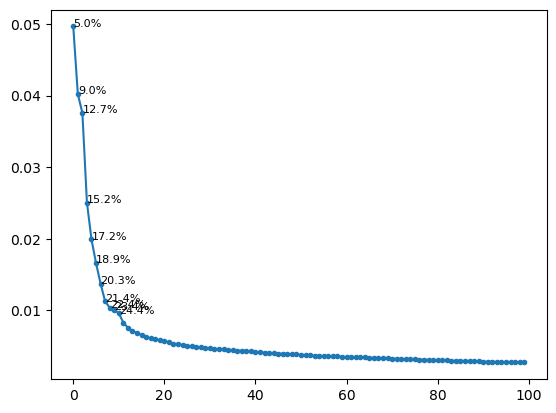

In [18]:
evr = PCA().fit(M_scaled).explained_variance_ratio_  #get all 60 variances
plt.plot(evr[:100], '.-')
for i,v in enumerate(evr.cumsum()[:11]):     
    plt.text(i,evr[i],f'{v:.1%}', fontsize=8)

In [19]:
y_train = np.array([[i]*50 for i in range(8)]).flatten()
y_test  = np.array([[i]*20 for i in range(8)]).flatten()
clrs8 = np.array([f'C{i}' for i in range(8)])

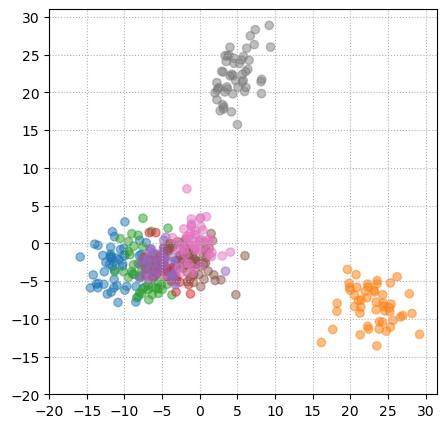

In [20]:
fig=plt.figure(figsize=(5,5))
plt.scatter(*M_new.T[:2], c=clrs8[y_train], alpha=.5)
plt.xticks(range(-20,35,5));
plt.yticks(range(-20,35,5));
plt.grid(ls=':')

In [21]:
from matplotlib.lines import Line2D #to make custom legend handles
def lmarker(c, m='o', ms=7): return Line2D([0], [0], marker=m, c='none', mfc=c, mec='none', ms=ms)

auths = ['austen','bible','chesterton','edgeworth','melville','milton','whitman','shakespeare']

def mylegend(loc='upper right'): return ax.legend([lmarker(f'C{i}') for i in range(8)], auths,
           loc=loc, fontsize=8)

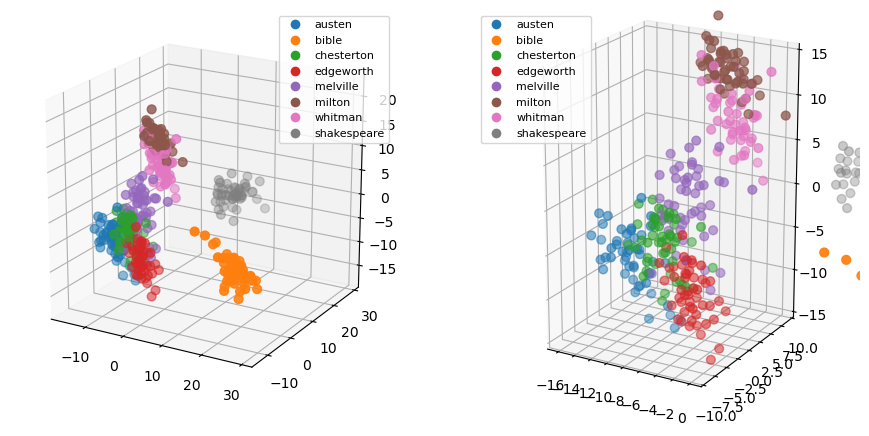

In [22]:
fig=plt.figure(figsize=(11,5))
ax = fig.add_subplot(121, projection='3d', elev=20)
ax.set_box_aspect((1,1,1))
ax.scatter(*M_new.T, c=clrs8[y_train], s=40);
mylegend()

ax = fig.add_subplot(122, projection='3d', elev=20)
ax.set_box_aspect((18,20,30))
ax.scatter(*M_new.T, c=clrs8[y_train], s=40)
ax.set_xlim(-17,1)
ax.set_ylim(-10,10)
ax.set_zlim(-15,15)
mylegend('upper left');

dates:

shakespeare 1599, 1603, 1603<br>
bible-kjv.txt 1611<br>
milton-paradise 1667<br>
edgeworth-parents 1796<br>
austen-sense 1811<br>
melville-moby_dick 1851<br>
whitman-leaves 1885<br>
chesterton-ball 1909

In [23]:
clf = SVC()
print(clf.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [24]:
cv10 = cross_val_score(clf, M_scaled, y_train, cv=5)
print (2000, f'mean={cv10.mean()}')

2000 mean=0.9974999999999999


In [25]:
clf.fit(M_scaled,y_train)
clf.score(T_scaled,y_test)

0.99375

In [26]:
X_data = np.vstack([M_scaled,T_scaled])
y_data = np.concatenate([y_train,y_test])

In [27]:
#param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
#param_grid = {'C': np.arange(1,4,.25),
#              'gamma': np.arange(.00004,.00006,.0000025) }

param_grid = {'C': np.arange(1,6),
              'gamma': np.arange(.00002,.0001,.00001) }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)

In [28]:
%%time
clf = clf.fit(X_data, y_data)

CPU times: user 34.7 s, sys: 0 ns, total: 34.7 s
Wall time: 34.7 s


In [29]:
clf.best_estimator_

SVC(C=2, class_weight='balanced', gamma=5.000000000000001e-05)

so use that best estimator:

In [30]:
clf = SVC(C=2,gamma=.00005)

In [31]:
cross_validate(clf, X_data, y_data, return_train_score=True, cv=5)

{'fit_time': array([0.13096046, 0.1378901 , 0.13611984, 0.12958765, 0.12149215]),
 'score_time': array([0.04237628, 0.04291463, 0.04252553, 0.04222894, 0.0419414 ]),
 'test_score': array([0.99107143, 1.        , 1.        , 1.        , 0.99107143]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [32]:
14*8, 111/112

(112, 0.9910714285714286)

In [33]:
%%time
clf = clf.fit(X_data, y_data)

CPU times: user 135 ms, sys: 0 ns, total: 135 ms
Wall time: 135 ms


Now check the dependence on size of feature set:

In [34]:
clf = SVC(C=2,gamma=.00005)
nfs = [1,10,25,50,75,100,250,500,750,1000,1500,2000] # + list(range(1000,5100,500))
means = []
for Nf in nfs:
    cv10 = cross_val_score(clf, X_data[:,:Nf], y_data, cv=5)
    means.append(cv10.mean())
    print (Nf, f'mean={cv10.mean()}') #not cv10

1 mean=0.30892857142857144
10 mean=0.5392857142857144
25 mean=0.7303571428571429
50 mean=0.8232142857142858
75 mean=0.8607142857142858
100 mean=0.9232142857142855
250 mean=0.9732142857142858
500 mean=0.9767857142857144
750 mean=0.9839285714285714
1000 mean=0.9928571428571429
1500 mean=0.9946428571428572
2000 mean=0.9964285714285716


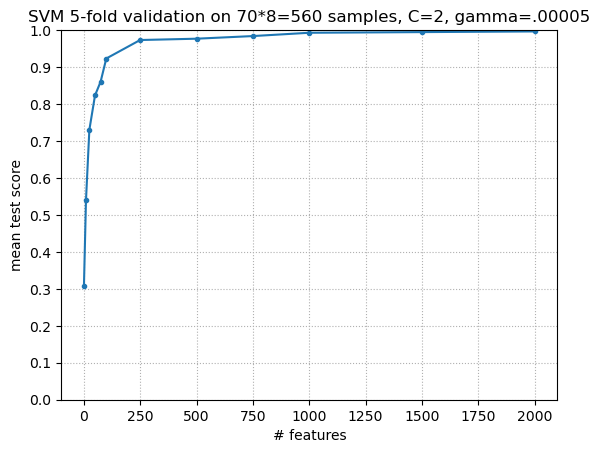

In [35]:
plt.plot(nfs,means,'.-')
plt.ylim(0,1)
plt.title('SVM 5-fold validation on 70*8=560 samples, C=2, gamma=.00005')
plt.xlabel('# features')
plt.ylabel('mean test score')
plt.yticks(np.arange(0,1.1,.1))
plt.grid(ls=':');

But letter tri-grams can be subject area dependent, try other texts by same authors (file below with four texts from shakespeare/edgeworth/melville/whitman available as [txts.zip](https://courses.cit.cornell.edu/info3950_2023sp/txts.zip)):

In [36]:
from urllib.request import urlopen
mpr_text = urlopen('https://www.gutenberg.org/cache/epub/58/pg58.txt').read().decode('utf-8')[767:93590]
sh_ac = open('a_and_c.txt',encoding='utf-8').read() #https://gutenberg.org/cache/epub/1534/pg1534.txt
ed_ta = open('edgeworth_tales.txt',encoding='utf-8').read() #https://gutenberg.org/files/8531/8531-0.txt
me_pi = open('me-piazza.txt',encoding='utf-8').read() #https://gutenberg.org/ebooks/15859
wh_dr = open('wh-drum.txt',encoding='utf-8').read()  #https://gutenberg.org/cache/epub/8801/pg8801.txt

In [37]:
T2 = []
for f in ('austen-persuasion.txt', 'austen-emma.txt', 'bible-kjv.txt',
          'chesterton-thursday.txt', 'chesterton-brown.txt', ed_ta, me_pi, mpr_text, wh_dr, sh_ac):
    if f.endswith('.txt'):
        txt = re.sub('\s+',' ', gutenberg.open(f).read().lower())
    else: #mpr,sh
        txt = re.sub('\s+',' ', f.lower())
        f = txt[:40]

    if f=='bible-kjv.txt':  txt = txt[2000000:]
    if 'cleopatra' in txt[:100]:  txt = txt[40000:]
    print(f, len(txt), len(txt)/5000)
    for i in range(16):
        txtblock = txt[5000*i:5000*(i+1)]
        c = Counter([txtblock[i:i+3] for i in range(5000-2)])
        T2.append([c[g3] for g3 in top2000])

austen-persuasion.txt 463331 92.6662
austen-emma.txt 880782 176.1564
bible-kjv.txt 2305687 461.1374
chesterton-thursday.txt 319184 63.8368
chesterton-brown.txt 397874 79.5748
﻿chapter i. “there is helen in the lime- 996595 199.319
﻿the piazza. “with fairest flowers, whil 462231 92.4462
 paradise regained by john milton conten 89558 17.9116
﻿drum-taps first o songs for a prelude.  61515 12.303
﻿act i scene i. alexandria. a room in cl 107652 21.5304


In [38]:
T2_scaled = scaler.transform(T2)
y2_test = [0]*32 + [1]*16 + [2]*32 + [3]*16 + [4]*16 + [5]*16 + [6]*16 + [7]*16
T2_scaled.shape, len(y2_test)

((160, 2000), 160)

In [39]:
clf.fit(X_data,y_data)
clf.score(T2_scaled,y2_test)

0.8875

In [40]:
clf.predict(T2_scaled)

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 3, 0, 3, 0,
       3, 3, 4, 0, 3, 0, 3, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 7, 7, 7, 7, 1, 7, 1, 7, 7, 1,
       7, 7, 7, 7, 7, 7])

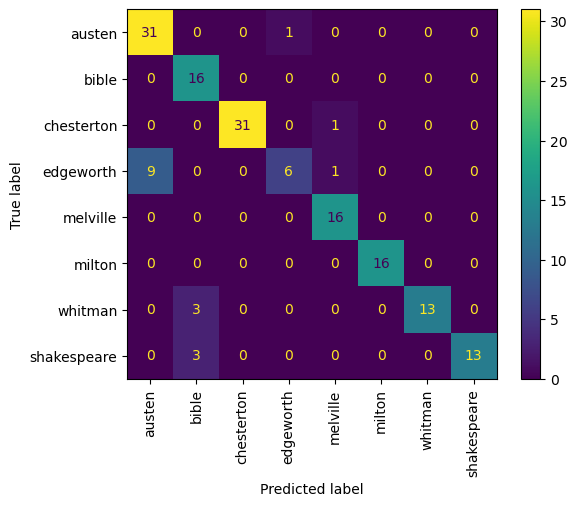

In [41]:
ConfusionMatrixDisplay.from_estimator(clf,T2_scaled,y2_test,
                    display_labels=auths, xticks_rotation='vertical');

BUT: using the most common letter 3-grams from the new data as features would not have been cheating, as long as still using most common and not "most discriminating", i.e., not using labels. So could do even better than the above